# Analisis de los resultados del procesamiento
### Proceso implementado en este notebook:
1. Importar librerias y definir variables

2. Lectura de los archivos binarios que contienen el procesamiento de los sujetos

3. Estimacion del estadistico:
    - hrr: hfo resection ratio
    - Esta variable define que tan contenida esta el area definida como hfo dentro del area de reseccion 
    
4. Modelo de regresion logistica Outcome vs hrr
    - la variable outcome es cualitativa pero se conierte a cuantitativa  bajo el siguiente criterio:
        - outocme S => 1
        - outcome F => 0
    

In [15]:
import pickle
import os
import xarray as xr
import numpy as np

from src.utils.read_data_from_bids import read_four_subjects
from src.utils.plots.hfo_plots import *
from src.utils.evaluation.evaluation import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

processed_data_directory = "data/processed"
results_directory = "data/results"

#argumentos descriptores de la base de datos
kwargs_bids= {
    'dataset':'data/bids/ds004100',
    'datatype':'ieeg',
    'task':'interictal',
    'acquisition':'seeg',
    'run':'01'
} 

In [2]:
files = os.listdir(processed_data_directory)

datasets = []
for archivo in files:
    if archivo.endswith(".pickle"):
        ruta_archivo = os.path.join(processed_data_directory, archivo)

        with open(ruta_archivo, "rb") as file:
            data = pickle.load(file)
    datasets.append(data)


In [3]:
# Crea un diccionario vacío para almacenar los datos
data = {}

# Define las coordenadas vacías
data['statisicians'] = []
data['algorithm_params'] = []

# Crea un objeto Dataset vacío con las coordenadas especificadas
ds = xr.Dataset(data)

#asignacion de coordenadas
ds = ds.assign_coords(statisicians = ['hrr', 'outcome'])

subject_dataset = datasets[0]
for element in subject_dataset:
    new_param = element
    ds = ds.assign_coords(algorithm_params=ds['algorithm_params'].values.tolist() + [new_param])



In [ ]:
for subject_dataset in datasets:
    
    subject_id = subject_dataset.attrs['his_id']
    raw, channels = read_four_subjects([subject_id.replace('sub-', '')] ,**kwargs_bids)
    
    hrr_list = []
    outcomes = []

    for element in subject_dataset:
        
        df = subject_dataset[element].to_pandas().T.reset_index()
        df = df.drop(df[df['colors'].isna()].index)
        for bad in raw[0].info['bads']:
            df = df.drop(df[df['ch_split'] == bad].index)    

        condicion = df['status'].isin(['resect', 'resect,soz'])
        filtrado = df[condicion]
        contadores = filtrado['status'].value_counts()

        resection_size = contadores.sum()
        resection_size = round(resection_size/2) 
        
        hfo_region = df.sort_values('counts', ascending=False).head(resection_size)
        condicion = hfo_region['status'].isin(['resect', 'resect,soz'])
        filtrado = hfo_region[condicion]
        contadores = filtrado['status'].value_counts()

        hfo_in_resection = contadores.sum()

        #hrr = round((hfo_in_resection/resection_size),2) + np.random.random() * 0.1 - 0.05#hfo resection ratio
        hrr = round((hfo_in_resection/resection_size),2)
        hrr_list.append(hrr)
                
        if subject_dataset.attrs['outcome'] == 'S':
            outcomes.append(1)
        else:
            outcomes.append(0)

    fusion = list(zip(hrr_list, outcomes))
    fusion_lista = [list(fila) for fila in fusion]

    ds[subject_dataset.attrs['his_id']] = xr.DataArray(fusion_lista, dims=('algorithm_params', 'statisicians'))


In [ ]:
df_decode_detect = pd.DataFrame({'name':[], 'combination':[]})
df_process = get_dataframe_results(datasets)

for i, element in enumerate(ds.coords["algorithm_params"].values):
    df = ds.sel(algorithm_params = element).to_pandas().T
    df_drop = df.drop("algorithm_params")
    
    df_process = df_process.join(df_drop['hrr']).rename(columns={'hrr': f'hrr_detect_C{i+1}'})
    df_decode_detect = df_decode_detect.append({'name': f'hrr_detect_C{i+1}', 'combination': element}, ignore_index=True)


In [23]:
df_process.head()

,age,sex,hand,outcome,engel,therapy,implant,target,lesion_status,age_onset,...,hrr_detect_C33,hrr_detect_C34,hrr_detect_C35,hrr_detect_C36,hrr_detect_C37,hrr_detect_C38,hrr_detect_C39,hrr_detect_C40,hrr_detect_C41,hrr_detect_C42
id,,,,,,,,,,,,,,,,,,,,,
sub-HUP160,45,2,0,S,1A,RESECTION,SEEG,TEMPORAL,NON-LESIONAL,15,...,0.17,0.17,0.0,0.17,0.17,0.17,0.17,0.33,0.17,0.17
sub-HUP190,25,1,2,F,3A,RESECTION,SEEG,MTL,NON-LESIONAL,12,...,0.17,0.17,0.08,0.17,0.17,0.17,0.17,0.17,0.17,0.17
sub-HUP138,38,1,2,F,4A,ABLATION,SEEG,MTL,LESIONAL,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-HUP187,25,1,0,F,2A,ABLATION,SEEG,MTL,NON-LESIONAL,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-HUP162,35,2,0,F,3A,ABLATION,SEEG,MTL,NON-LESIONAL,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'bw-(130, 190)_ww-90')

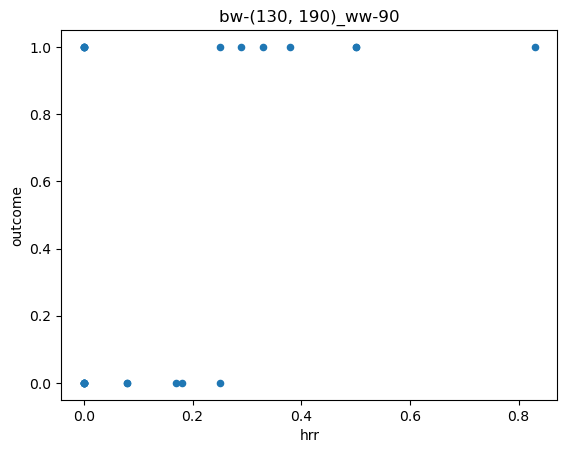

In [22]:
df = ds.sel(algorithm_params = 'bw-(130, 190)_ww-90').to_pandas().T
df_drop = df.drop("algorithm_params")
df_drop[['hrr','outcome']].plot.scatter(x='hrr',y='outcome').set_title('bw-(130, 190)_ww-90')

In [40]:
# %% optimizacion de parametors de regresión logistica
train = df_drop
# definiendo input y output
X_train = np.array(train['hrr']).reshape((-1, 1))
Y_train = np.array(train['outcome'])
Y_train = Y_train.astype(int)

# creando modelo
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)
print(classification_report(Y_train, Y_pred))
#print(f'Score: {model.score(X_train, Y_train)}')

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.70      0.58      0.64        12

    accuracy                           0.67        24
   macro avg       0.67      0.67      0.66        24
weighted avg       0.67      0.67      0.66        24



In [41]:
df_process

,age,sex,hand,outcome,engel,therapy,implant,target,lesion_status,age_onset,...,hrr_detect_C33,hrr_detect_C34,hrr_detect_C35,hrr_detect_C36,hrr_detect_C37,hrr_detect_C38,hrr_detect_C39,hrr_detect_C40,hrr_detect_C41,hrr_detect_C42
id,,,,,,,,,,,,,,,,,,,,,
sub-HUP160,45,2,0,S,1A,RESECTION,SEEG,TEMPORAL,NON-LESIONAL,15,...,0.17,0.17,0.0,0.17,0.17,0.17,0.17,0.33,0.17,0.17
sub-HUP190,25,1,2,F,3A,RESECTION,SEEG,MTL,NON-LESIONAL,12,...,0.17,0.17,0.08,0.17,0.17,0.17,0.17,0.17,0.17,0.17
sub-HUP138,38,1,2,F,4A,ABLATION,SEEG,MTL,LESIONAL,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-HUP187,25,1,0,F,2A,ABLATION,SEEG,MTL,NON-LESIONAL,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-HUP162,35,2,0,F,3A,ABLATION,SEEG,MTL,NON-LESIONAL,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-HUP146,16,1,0,S,1A,RESECTION,SEEG,TEMPORAL,NON-LESIONAL,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-HUP148,23,1,0,S,1A,ABLATION,SEEG,TEMPORAL,LESIONAL,16,...,0.67,0.83,0.83,0.83,0.33,0.17,0.33,0.33,0.33,0.5
sub-HUP144,31,1,0,S,1D,RESECTION,SEEG,TEMPORAL,LESIONAL,5,...,0.29,0.29,0.14,0.29,0.43,0.43,0.29,0.29,0.29,0.29
sub-HUP133,52,2,2,F,3A,ABLATION,SEEG,MTL,NON-LESIONAL,47,...,0.25,0.25,0.25,0.25,0.0,0.25,0.25,0.25,0.0,0.0
